<a href="https://colab.research.google.com/github/sakib7/ml-project-versioning/blob/main/lstm_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Utilities
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [23]:
url = "https://raw.githubusercontent.com/sakib7/IT00CD79-3005-Machine-Learning/main/Sentiment140.tenPercent.sample.tweets.tsv"
dataset = pd.read_csv(url, delimiter="\t")
dataset['sentiment'] = dataset['sentiment_label'].replace(4,1)
dataset['text'] = dataset['tweet_text']
dataset = dataset.drop(columns=['tweet_text', 'sentiment_label'])
# print(dataset.head(10))
dataset

,sentiment,text
0,1,"@elephantbird Hey dear, Happy Friday to You A..."
1,1,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...
...,...,...
159995,0,STILL @ panera...studying for &quot;mock&quot;...
159996,0,Insomnia is out of control tonight--haven't sl...
159997,1,@Covergirl08 I take pride in what I do
159998,1,heading to work on the 6


In [24]:
# Reading contractions.csv and storing it as a dict.
contractions = pd.read_csv('https://raw.githubusercontent.com/sakib7/IT00CD79-3005-Machine-Learning/main/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'', tweet)

    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [25]:
%%time
dataset['processed_text'] = dataset.text.apply(preprocess_apply)

CPU times: user 9.31 s, sys: 43 ms, total: 9.36 s
Wall time: 9.52 s


In [26]:
count=0
for row in dataset.itertuples():
    print("Text:", row[2])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break

Text: @elephantbird Hey dear, Happy Friday to You  Already had your rice's bowl for lunch ?
Processed:  hey dear  happy friday to you  already had your riceis bowl for lunch  
Text: Ughhh layin downnnn    Waiting for zeina to cook breakfast
Processed: ughh layin downn  waiting for zeina to cook breakfast
Text: @greeniebach I reckon he'll play, even if he's not 100%...but i know nothing!! ;) It won't be the same without him. 
Processed:  i reckon he will play  even if he is not 100   but i know nothing   <smile> it will not be the same without him  
Text: @vaLewee I know!  Saw it on the news!
Processed:  i know   saw it on the news 
Text: very sad that http://www.fabchannel.com/ has closed down. One of the few web services that I've used for over 5 years 
Processed: very sad that  has closed down  one of the few web services that i have used for over 5 years 
Text: @Fearnecotton who sings 'I Remember'? i alwaysss hear it on Radio 1 but never catch the artist 
Processed:  who sings  i re

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.05, random_state = 0)
print('Data Split done.')

Data Split done.


In [29]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [30]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 13708
CPU times: user 21.3 s, sys: 130 ms, total: 21.4 s
Wall time: 12.7 s


In [31]:
# Defining the model input length.
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [32]:
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)
tokenizer.word_index['love']

Tokenizer vocab length: 60000


48

In [33]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

print(X_train[10:15])
print(X_train_sequences[10:15])

[' yet again  a diss goes rght past u dork   and how the hell did u get more followers  meanie'
 'i have a sad feeling that dallas is not going to show up  i got to say though  you would think more shows would use music from the game  mm'
 '  glad to hear that you have great friends kyanna  im sorry to hear about your family'
 'what am i going to do  my ipod is dying     nowhere near a charger'
 ' they are trying to confuse you  and it seems to work  ']
[[209, 107, 5, 9803, 520, 28327, 728, 55, 4158, 8, 69, 4, 451, 67, 55, 37, 86, 387, 5202], [2, 16, 5, 111, 181, 20, 2610, 6, 11, 34, 3, 171, 33, 2, 42, 3, 166, 129, 10, 101, 78, 86, 840, 101, 358, 327, 54, 4, 306, 649], [271, 3, 264, 20, 10, 16, 100, 198, 48183, 60, 119, 3, 264, 59, 46, 338], [57, 15, 2, 34, 3, 23, 7, 624, 6, 1002, 2087, 1010, 5, 2202], [75, 26, 222, 3, 6490, 10, 8, 9, 488, 3, 47]]


In [34]:
X_train = pad_sequences(X_train_sequences, maxlen=input_length)
X_test  = pad_sequences(X_test_sequences , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)
X_train[10], X_test[10]

X_train.shape: (152000, 60)
X_test.shape : (8000, 60)


(array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,   209,   107,     5,  9803,
          520, 28327,   728,    55,  4158,     8,    69,     4,   451,
           67,    55,    37,    86,   387,  5202], dtype=int32),
 array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    40,  2962, 38942], dtype=int32))

In [35]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)
embedding_matrix[50]

Embedding Matrix Shape: (60000, 100)


array([ 5.05512714e-01, -1.59827501e-01,  7.06434786e-01,  6.61882520e-01,
       -3.31894308e-01, -4.43751097e-01,  6.76516235e-01,  2.87027627e-01,
        1.88821688e-01, -1.18944108e+00,  7.29842842e-01, -8.79217327e-01,
        8.73405579e-03, -3.76059026e-01,  1.58359158e+00,  2.87258774e-01,
        9.58847404e-02, -5.96060045e-02,  1.22222066e+00, -1.03916883e-01,
        9.61065829e-01, -7.37687886e-01,  4.84279275e-01, -9.10362661e-01,
        1.93207741e-01, -3.69526178e-01, -1.02681017e+00, -4.41349447e-01,
       -5.13517499e-01, -6.44369364e-01, -8.13702792e-02, -8.50892216e-02,
        1.06390250e+00, -9.73385200e-02, -4.14891183e-01, -1.04208124e+00,
       -1.98221266e-01,  3.68607670e-01,  5.32104969e-01, -9.68887031e-01,
        2.07164019e-01,  9.54457581e-01,  5.63207507e-01, -7.51512637e-03,
       -7.16097414e-01, -1.41554768e-03, -3.47718686e-01,  8.06472898e-01,
        6.27567112e-01,  6.84168816e-01, -8.97488058e-01,  4.00436401e-01,
        2.65235782e-01,  

In [36]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [37]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        LSTM(64, dropout=0.3, return_sequences=True),
        # Bidirectional(LSTM(64, dropout=0.3, return_sequences=True)),
        # Conv1D(64, 5, activation='relu'),
        GlobalMaxPool1D(),
        # Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model


In [38]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 100)           6000000   
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            42240     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6042305 (23.05 MB)
Trainable params: 42305 (165.25 KB)
Non-trainable params: 6000000 (22.89 MB)
_________________________________________________________________


In [39]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [40]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/7
268/268 [==============================] - 70s 253ms/step - loss: 0.5500 - accuracy: 0.7192 - val_loss: 0.4993 - val_accuracy: 0.7539 - lr: 0.0010
Epoch 2/7
268/268 [==============================] - 69s 256ms/step - loss: 0.5046 - accuracy: 0.7527 - val_loss: 0.4826 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 3/7
268/268 [==============================] - 69s 257ms/step - loss: 0.4902 - accuracy: 0.7624 - val_loss: 0.4780 - val_accuracy: 0.7661 - lr: 0.0010
Epoch 4/7
268/268 [==============================] - 69s 257ms/step - loss: 0.4813 - accuracy: 0.7674 - val_loss: 0.4661 - val_accuracy: 0.7776 - lr: 0.0010
Epoch 5/7
268/268 [==============================] - 69s 257ms/step - loss: 0.4735 - accuracy: 0.7724 - val_loss: 0.4594 - val_accuracy: 0.7822 - lr: 0.0010
Epoch 6/7
268/268 [==============================] - 69s 257ms/step - loss: 0.4681 - accuracy: 0.7759 - val_loss: 0.4568 - val_accuracy: 0.7845 - lr: 0.0010
Epoch 7/7
268/268 [==============================] - 69s 2

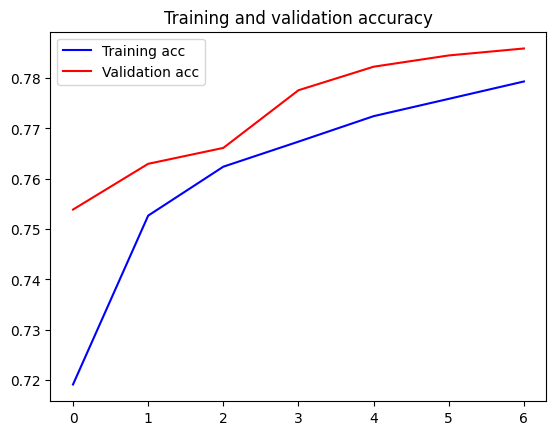

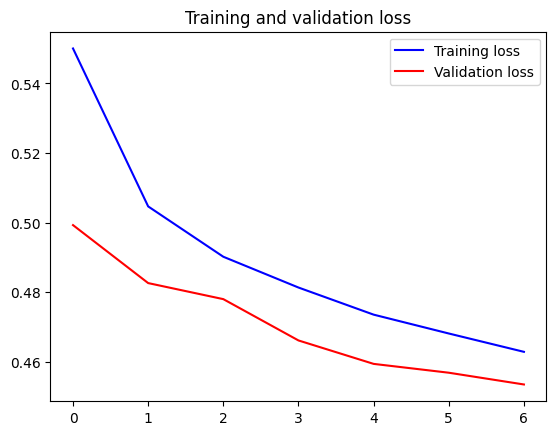

250/250 [==============================] - 3s 10ms/step
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      4061
           1       0.79      0.81      0.80      3939

    accuracy                           0.80      8000
   macro avg       0.80      0.80      0.80      8000
weighted avg       0.80      0.80      0.80      8000

CPU times: user 12min 27s, sys: 23.7 s, total: 12min 50s
Wall time: 8min 6s


In [41]:
%%time

history = training_model.fit(
    X_train, y_train,
    batch_size=512,
    epochs=7,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

from sklearn.metrics import confusion_matrix, classification_report

y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

print(classification_report(y_test, y_pred))